In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import pandas as pd 
from src.diagnostic import pre_stat, missingness_matrix, numerical_check
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import numpy as np




In [3]:

DATA_DIR=PROJECT_ROOT/'data'/'raw'

df_baseline=pd.read_csv(DATA_DIR / 'MigraineBaselineVars.csv',sep=';')

df_longitudinal=pd.read_csv(DATA_DIR / 'MigraineLongitudianlVars.csv',sep=';')
    


# baseline 

In [4]:
pre_stat(df_baseline)

,fraction_missing,count_missing,unique_value
SUBJECT_ID,0.000000,0,179
AGE,0.000000,0,51
SEX,0.000000,0,2
DIAGNOSIS,0.000000,0,3
Suspension,0.000000,0,2
MONTHS_OF_TREAT,0.000000,0,27
TREATMENT_DISC,0.000000,0,5
AGE_OF_ONSET,0.061453,11,32
AGE_W_CHRONICMIGRAINE,0.061453,11,39
FAMILIARITY,0.525140,94,2


In [5]:
df_baseline["Psycopathological"]

0      3.0
1      1.0
2      0.0
3      3.0
4      5.0
      ... 
174    NaN
175    NaN
176    NaN
177    NaN
178    NaN
Name: Psycopathological, Length: 179, dtype: float64

In [6]:
print(df_baseline.head(2))

   SUBJECT_ID  AGE  SEX  DIAGNOSIS  Suspension  MONTHS_OF_TREAT  \
0           1   57    1          3           0               36   
1           2   51    2          2           0               36   

  TREATMENT_DISC  AGE_OF_ONSET  AGE_W_CHRONICMIGRAINE  FAMILIARITY  ...  \
0      COMPLETED          15.0                   11.0          0.0  ...   
1      COMPLETED           8.0                   20.0          1.0  ...   

   Antiipnt  Pizotifene  Botulin  DETOXPRE  Psycopathological  Hypertension  \
0       0.0         1.0      1.0       0.0                3.0           0.0   
1       0.0         0.0      1.0       0.0                1.0           1.0   

   Sleep_Disorders  PREV_T0  GGCEF_T0  INT_T0  
0              0.0      1.0        13     6.0  
1              0.0      1.0        25     7.0  

[2 rows x 35 columns]


In [7]:
continuous_vars = [
    "AGE", "AGE_OF_ONSET", "AGE_W_CHRONICMIGRAINE",
    "WEIGTH", "HEIGTH", "BMI"
]

score_vars = [
    "HIT6", "MIDAS", "HADSA", "HADSD",
    "GGCEF_T0", "INT_T0"
]

count_vars = [
    "MONTHS_OF_TREAT",
    "NUM_TRAT"
]

categorical_vars = [
    # Demographics / diagnosis
    "SEX",
    "DIAGNOSIS",
    "SIDE",
    "ANTIBODY",

    # Clinical history / indicators
    "FAMILIARITY",
    "PULSATING",
    "PAIN_MOVMENT",
    "Aura",

    # Treatments (binary indicators)
    "Bbloc",
    "Caant",
    "Tricyclic",
    "Antiepil",
    "SSRISNRI",
    "Antiipnt",
    "Pizotifene",
    "Botulin",
    "DETOXPRE",

    # Comorbidities / conditions
    "Psycopathological",
    "Hypertension",
    "Sleep_Disorders",

    # Treatment-related status
    "Suspension",
    "PREV_T0",
    "TREATMENT_DISC"
]



## exploration

In [8]:
num_summary = df_baseline[continuous_vars].describe().T
num_summary

,count,mean,std,min,25%,50%,75%,max
AGE,179.0,51.318436,14.337593,3.00,46.500,52.00,58.0000,123.00
AGE_OF_ONSET,168.0,15.595238,8.320121,3.00,10.000,14.00,18.0000,53.00
AGE_W_CHRONICMIGRAINE,168.0,14.178571,10.348607,1.00,6.000,12.00,19.2500,47.00
WEIGTH,86.0,66.619767,14.009264,43.50,56.875,65.00,75.0000,120.00
HEIGTH,78.0,3.729872,18.268204,1.50,1.600,1.65,1.7275,163.00
BMI,77.0,23.694156,3.479108,17.26,20.930,23.71,25.4300,34.11


In [9]:
issues = numerical_check(df_baseline, exclude={"SUBJECT_ID"})

context_cols = ["SUBJECT_ID", "AGE", "AGE_OF_ONSET", "AGE_W_CHRONICMIGRAINE", "WEIGTH", "HEIGTH", "BMI"]

for col, info in issues.items():
    idx = info["extreme_values"].index
    cols_to_show = [c for c in context_cols if c in df_baseline.columns]
    if col not in cols_to_show:
        cols_to_show.append(col)

    print(f"\n=== {col} ===")
    print(df_baseline.loc[idx, cols_to_show].to_string(index=False))





=== AGE ===
 SUBJECT_ID  AGE  AGE_OF_ONSET  AGE_W_CHRONICMIGRAINE  WEIGTH  HEIGTH   BMI
         63   18          11.0                    6.0     NaN     NaN   NaN
         88    3          10.0                   17.0    53.0    1.64 19.71
         98  123          15.0                   10.0    73.0    1.72 24.68
        107  123          18.0                   13.0     NaN     NaN   NaN

=== MONTHS_OF_TREAT ===
 SUBJECT_ID  AGE  AGE_OF_ONSET  AGE_W_CHRONICMIGRAINE  WEIGTH  HEIGTH   BMI  MONTHS_OF_TREAT
         92   63          13.0                   47.0    69.0    1.55 28.72                3

=== AGE_OF_ONSET ===
 SUBJECT_ID  AGE  AGE_OF_ONSET  AGE_W_CHRONICMIGRAINE  WEIGTH  HEIGTH   BMI
          3   30           4.0                    5.0    59.0    1.65 21.67
         36   60          46.0                    5.0    50.0    1.65 18.37
         59   53          53.0                   23.0     NaN     NaN   NaN
        136   31           3.0                   25.0     NaN     NaN 

In [10]:
cond1 = df_baseline["AGE_OF_ONSET"] > df_baseline["AGE"]
cond2 = df_baseline["AGE_W_CHRONICMIGRAINE"] > df_baseline["AGE"]
cond3 = df_baseline["AGE_W_CHRONICMIGRAINE"] > (df_baseline["AGE"] - df_baseline["AGE_OF_ONSET"])
cond4 = ~df_baseline["AGE"].between(4, 120)   # invalid age

invalid_mask = cond1 | cond2 | cond3 | cond4

df_baseline = df_baseline[~invalid_mask]




In [11]:
df_baseline["HEIGTH"] = np.where(
    df_baseline["HEIGTH"] > 3,
    df_baseline["HEIGTH"] / 100,
    df_baseline["HEIGTH"]
)

In [12]:
# (Optional) coerce to numeric if your columns are strings
w = pd.to_numeric(df_baseline["WEIGTH"], errors="coerce")
h = pd.to_numeric(df_baseline["HEIGTH"], errors="coerce")
b = pd.to_numeric(df_baseline["BMI"], errors="coerce")

bmi_calc = w / (h ** 2)

# only check rows where all three values exist and height is positive
checkable = w.notna() & h.notna() & b.notna() & (h > 0)

tol = 0.5  # tolerance in BMI units (0.1–0.5 are common; pick what fits your data)
cond_bmi_bad = checkable & ((b - bmi_calc).abs() > tol)

print("BMI inconsistent rows:", cond_bmi_bad.sum())

BMI inconsistent rows: 1


In [13]:
df_baseline.loc[cond_bmi_bad, ["SUBJECT_ID", "WEIGTH", "HEIGTH", "BMI"]].assign(
    BMI_calc=bmi_calc[cond_bmi_bad].round(2),
    BMI_diff=(b[cond_bmi_bad] - bmi_calc[cond_bmi_bad]).round(2)
)


,SUBJECT_ID,WEIGTH,HEIGTH,BMI,BMI_calc,BMI_diff
78,79,45.0,1.63,21.88,16.94,4.94


In [14]:
df_baseline = df_baseline[df_baseline["SUBJECT_ID"] != 79]

num treat and month are equa, hence one of them is not only usless for information  but it creates a problem of multicollinearity, same as bmi 

In [15]:
check = df_baseline["NUM_TRAT"].equals(df_baseline["MONTHS_OF_TREAT"])
print(check)

True


In [16]:
df_baseline = df_baseline.drop(columns=["NUM_TRAT"])

In [17]:
df_baseline.to_csv("df_baseline_clean.csv", index=False)

### distributions

i will plot them after cleaning the data

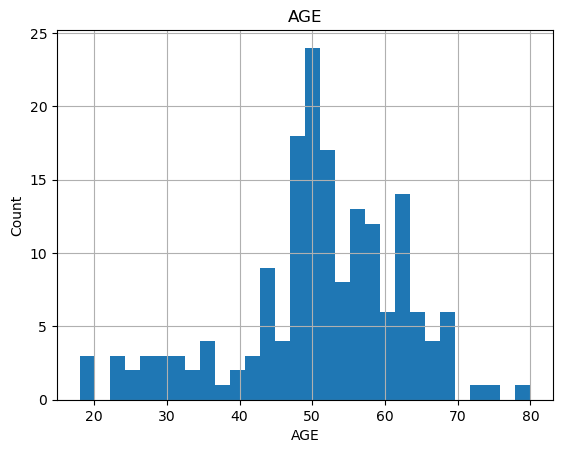

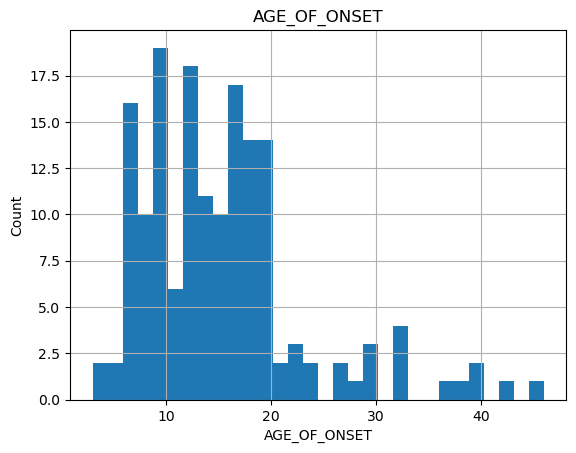

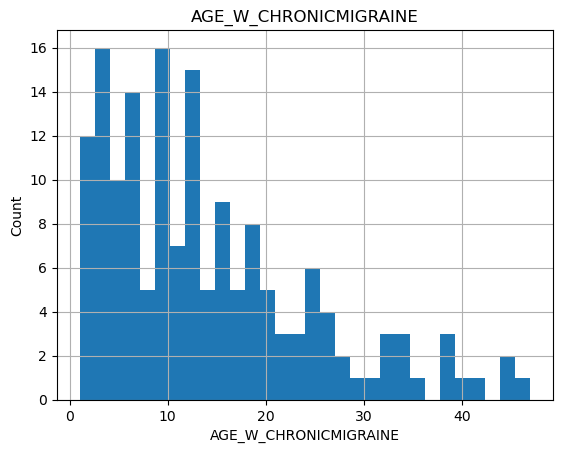

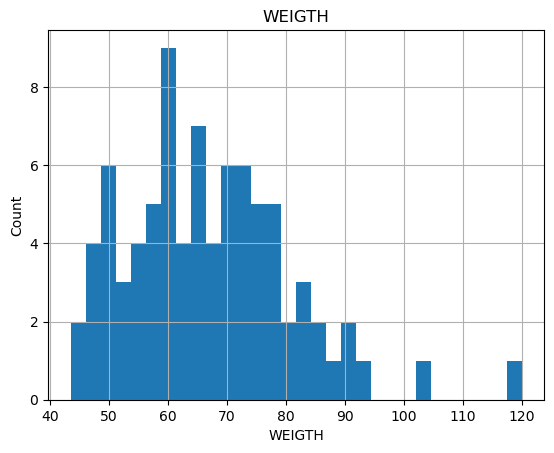

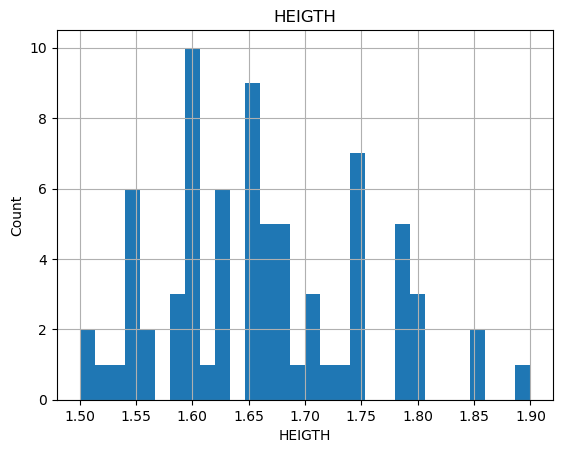

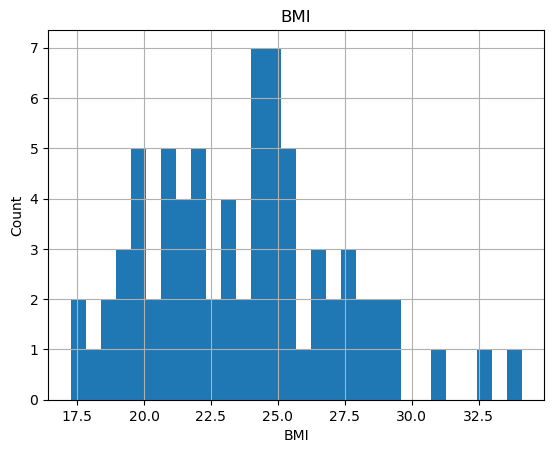

In [18]:
for col in continuous_vars:
    if df_baseline[col].nunique() > 2:
        plt.figure()
        df_baseline[col].dropna().hist(bins=30)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()


## missing values 


In [19]:
missing_pattern_baseline=missingness_matrix(df_baseline)
missing_pattern_longitudinal=missingness_matrix(df_longitudinal)

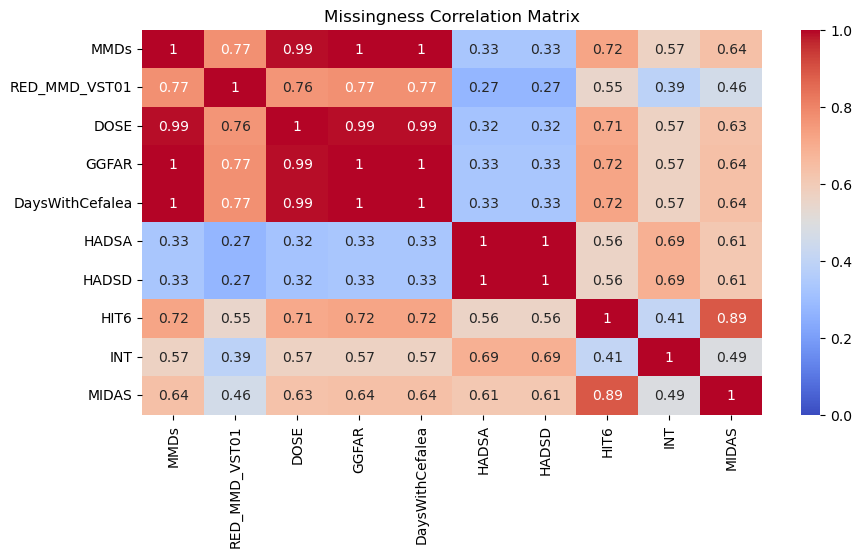

In [20]:
plt.figure(figsize=(10, 5))
sns.heatmap(missing_pattern_longitudinal,
            annot=True,
            cmap="coolwarm",
            vmin=0,
            vmax=1
    )
plt.title("Missingness Correlation Matrix")
plt.show()

The missingness correlation matrix reveals two dominant clusters of variables with near-perfect co-missingness, indicating that missingness is governed by shared latent mechanisms rather than random noise. The strong dependence between missingness indicators rejects the MCAR assumption. Furthermore, moderate correlations between missingness indicators and other observed clinical scales suggest that missingness is partially predictable from observed data, supporting the plausibility of a MAR mechanism.

In [23]:
df_baseline[df_baseline["AGE_W_CHRONICMIGRAINE"] == 47]

,SUBJECT_ID,AGE,SEX,DIAGNOSIS,Suspension,MONTHS_OF_TREAT,TREATMENT_DISC,AGE_OF_ONSET,AGE_W_CHRONICMIGRAINE,FAMILIARITY,...,Antiipnt,Pizotifene,Botulin,DETOXPRE,Psycopathological,Hypertension,Sleep_Disorders,PREV_T0,GGCEF_T0,INT_T0
91,92,63,1,1,1,3,INEFFICACIA,13.0,47.0,1.0,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,28,NaN


# longitudinal 


In [24]:
pre_stat(df_longitudinal)

,fraction_missing,count_missing,unique_value
SUBJECT_ID,0.000000,0,179
SEQUENCE,0.000000,0,15
CYCLE,0.000000,0,3
MONTH,0.000000,0,5
MMDs,0.400000,1074,32
RED_MMD_VST01,0.525512,1411,43
DOSE,0.402235,1080,88
GGFAR,0.398883,1071,32
DaysWithCefalea,0.398883,1071,32
HADSA,0.699069,1877,22


In [25]:
df_longitudinal

,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS,R_block
0,1,1,1,1,13.0,NaN,15.0,13.0,13.0,3.0,5.0,63.0,6.0,63.0,0
1,2,1,1,1,24.0,NaN,34.0,22.0,25.0,11.0,7.0,64.0,7.0,29.0,0
2,3,1,1,1,25.0,NaN,87.0,28.0,28.0,1.0,0.0,70.0,7.0,55.0,0
3,4,1,1,1,24.0,NaN,30.0,25.0,25.0,4.0,2.0,64.0,5.0,87.0,0
4,5,1,1,1,16.0,NaN,18.0,16.0,16.0,5.0,3.0,59.0,6.0,60.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,183,15,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2681,184,15,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2682,185,15,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2683,186,15,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [26]:
key = ["SUBJECT_ID", "CYCLE", "MONTH"]

dups = df_longitudinal[df_longitudinal.duplicated(key, keep=False)].sort_values(key)
print("Duplicate rows:", len(dups))
dups.head(10)

Duplicate rows: 0


,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS,R_block


In [27]:
expected_cycles = {1, 2, 3}
expected_months = {1, 3, 6, 9, 12}

grid = (
    df_longitudinal.groupby("SUBJECT_ID")
      .apply(lambda x: pd.Series({
          "cycles_present": set(x["CYCLE"].dropna().astype(int)),
          "months_present": set(x["MONTH"].dropna().astype(int)),
          "n_rows": len(x)
      }))
      .reset_index()
)

grid["missing_cycles"] = grid["cycles_present"].apply(lambda s: expected_cycles - s)
grid["missing_months"] = grid["months_present"].apply(lambda s: expected_months - s)

grid.head()

C:\Users\aless\AppData\Local\Temp\ipykernel_27336\3274419517.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,SUBJECT_ID,cycles_present,months_present,n_rows,missing_cycles,missing_months
0,1,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}
1,2,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}
2,3,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}
3,4,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}
4,5,"{1, 2, 3}","{1, 3, 6, 9, 12}",15,{},{}


In [28]:
bad_grid = grid[
    (grid["missing_cycles"].astype(str) != "set()") |
    (grid["missing_months"].astype(str) != "set()")
]

print("Subjects with incomplete grid:", len(bad_grid))
bad_grid.head(10)


Subjects with incomplete grid: 0


,SUBJECT_ID,cycles_present,months_present,n_rows,missing_cycles,missing_months


In [29]:
miss_by_time = (
    df_longitudinal
    .groupby(["CYCLE", "MONTH"])
    .agg(lambda x: x.isna().mean())
    .reset_index()
)

miss_by_time.loc[:, ["MMDs", "DOSE", "GGFAR", "HIT6", "INT", "MIDAS"]]

,MMDs,DOSE,GGFAR,HIT6,INT,MIDAS
0,0.000000,0.000000,0.000000,0.217877,0.217877,0.217877
1,0.000000,0.000000,0.000000,0.223464,0.525140,0.251397
2,0.100559,0.100559,0.100559,0.307263,0.536313,0.318436
3,0.223464,0.223464,0.223464,0.413408,0.553073,0.497207
4,0.262570,0.262570,0.262570,0.452514,0.575419,0.530726
5,0.547486,0.547486,0.547486,0.357542,0.530726,0.368715
6,0.480447,0.480447,0.480447,0.357542,0.681564,0.396648
7,0.508380,0.558659,0.508380,0.374302,0.698324,0.391061
8,0.558659,0.558659,0.558659,0.391061,0.737430,0.491620
9,0.508380,0.491620,0.491620,0.391061,0.737430,0.474860


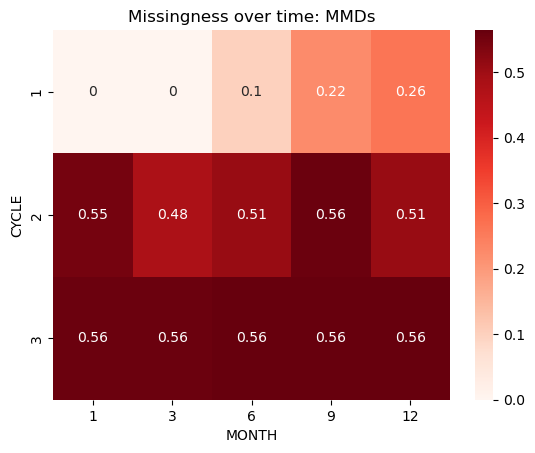

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    miss_by_time.pivot(index="CYCLE", columns="MONTH", values="MMDs"),
    cmap="Reds", annot=True
)
plt.title("Missingness over time: MMDs")
plt.show()


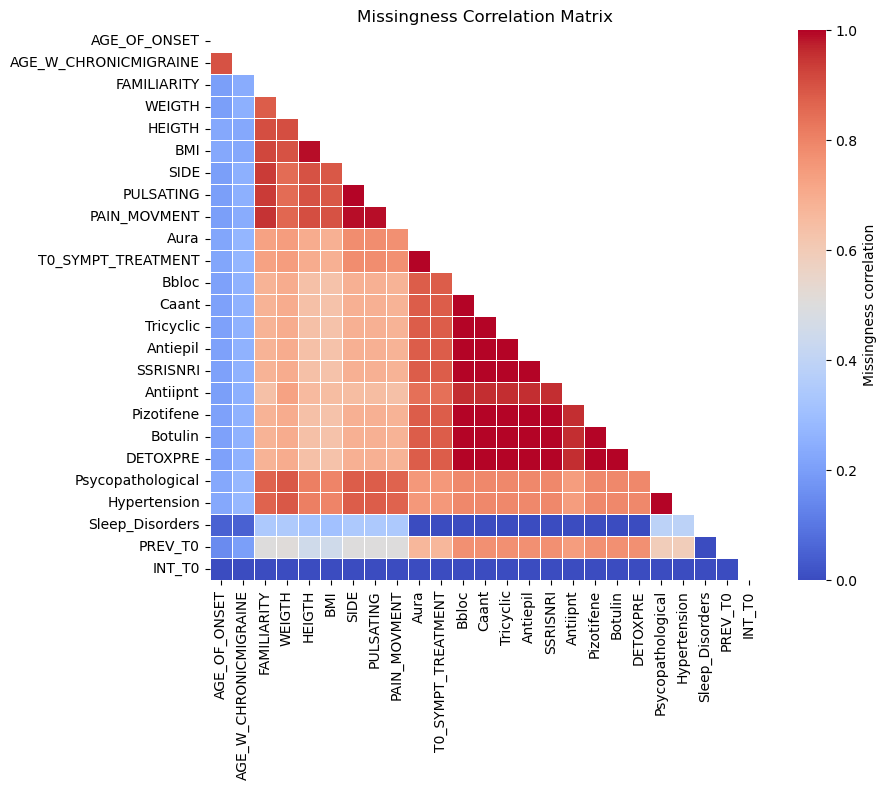

In [31]:
import numpy as np

mask = np.triu(np.ones_like(missing_pattern_baseline, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    missing_pattern_baseline,
    mask=mask,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Missingness correlation"}
)
plt.title("Missingness Correlation Matrix")
plt.tight_layout()
plt.show()

In [32]:
df_longitudinal[df_longitudinal["SUBJECT_ID"]== 1]


,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS,R_block
0,1,1,1,1,13.0,NaN,15.0,13.0,13.0,3.0,5.0,63.0,6.0,63.0,0
179,1,2,1,3,1.0,12.0,12.0,10.0,10.0,5.0,2.0,61.0,6.0,120.0,0
358,1,3,1,6,3.0,10.0,2.0,2.0,3.0,5.0,2.0,48.0,5.0,4.0,0
537,1,4,1,9,4.0,9.0,6.0,4.0,4.0,5.0,5.0,48.0,4.0,6.0,0
716,1,5,1,12,1.0,12.0,13.0,10.0,10.0,9.0,8.0,0.0,6.0,4.0,0
895,1,6,2,1,26.0,NaN,31.0,26.0,26.0,6.0,6.0,66.0,5.0,114.0,0
1074,1,7,2,3,5.0,8.0,5.0,5.0,5.0,6.0,6.0,54.0,5.0,17.0,0
1253,1,8,2,6,8.0,5.0,8.0,8.0,8.0,6.0,6.0,54.0,0.0,17.0,0
1432,1,9,2,9,8.0,5.0,8.0,8.0,8.0,6.0,6.0,54.0,0.0,17.0,0
1611,1,10,2,12,8.0,5.0,8.0,8.0,8.0,6.0,6.0,54.0,0.0,17.0,0


In [33]:
issues = numerical_check(
    df_longitudinal,
    exclude={"SUBJECT_ID", "SEQUENCE", "CYCLE", "MONTH", "R_block"}
)

context_cols = ["SUBJECT_ID", "CYCLE", "MONTH"]

for col, info in issues.items():
    idx = info["extreme_values"].index

    cols_to_show = [c for c in context_cols if c in df_longitudinal.columns]
    if col not in cols_to_show:
        cols_to_show.append(col)

    print(f"\n=== {col} ===")
    print(
        df_longitudinal.loc[idx, cols_to_show]
        .sort_values(by=["SUBJECT_ID", "CYCLE", "MONTH"])
        .to_string(index=False)
    )



=== MMDs ===
 SUBJECT_ID  CYCLE  MONTH  MMDs
         27      3      1  31.0

=== RED_MMD_VST01 ===
 SUBJECT_ID  CYCLE  MONTH  RED_MMD_VST01
         29      1      6           29.0
         53      1      9           -6.0
         59      2     12           30.0
         59      3      6           29.0
         59      3      9           29.0
         59      3     12           29.0
         69      3      9           29.0
         69      3     12           30.0
        119      1      3           -6.0
        128      1      3           -8.0
        128      1      6           -7.0
        134      2     12          -16.0
        140      1      3          -10.0
        150      1      6           30.0
        151      2     12           29.0
        164      1     12           -6.0
        167      2     12           -6.0
        182      1      3          -12.0
        182      2     12          -18.0

=== DOSE ===
 SUBJECT_ID  CYCLE  MONTH  DOSE
         47      1      1 170.0
 

In [34]:
df_longitudinal[df_longitudinal["DOSE"]> 170]

,SUBJECT_ID,SEQUENCE,CYCLE,MONTH,MMDs,RED_MMD_VST01,DOSE,GGFAR,DaysWithCefalea,HADSA,HADSD,HIT6,INT,MIDAS,R_block
141,144,1,1,1,30.0,NaN,180.0,30.0,30.0,NaN,NaN,74.0,8.0,192.0,0


In [35]:
# baseline row (adjust if needed)
baseline = (
    df_longitudinal
    .query("CYCLE == 1 and MONTH == 1")
    .loc[:, ["SUBJECT_ID", "MMDs"]]
    .rename(columns={"MMDs": "MMDs_baseline"})
)

df_chk = df_longitudinal.merge(baseline, on="SUBJECT_ID", how="left")



df_chk["RED_calc_reversed"] = df_chk["MMDs_baseline"] - df_chk["MMDs"]
df_chk["RED_diff_rev"] = df_chk["RED_MMD_VST01"] - df_chk["RED_calc_reversed"]

mask = (
    df_chk["RED_MMD_VST01"].notna() &
    df_chk["MMDs"].notna() &
    df_chk["MMDs_baseline"].notna()
)

tol = 1e-6
bad_rev = df_chk[mask & (df_chk["RED_diff_rev"].abs() > tol)]

print("Inconsistencies if RED = baseline - current:", len(bad_rev))
bad_rev[["SUBJECT_ID","CYCLE","MONTH","MMDs_baseline","MMDs","RED_MMD_VST01","RED_calc_reversed","RED_diff_rev"]].head(20)


Inconsistencies if RED = baseline - current: 0


,SUBJECT_ID,CYCLE,MONTH,MMDs_baseline,MMDs,RED_MMD_VST01,RED_calc_reversed,RED_diff_rev


# (A) Are baseline variables associated with longitudinal outcomes?

In [ ]:
baseline_vars=['AGE','SEX', 'DIAGNOSIS', 'Suspension'	,'MONTHS_OF_TREAT',	'TREATMENT_DISC']

